In [162]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn as sk
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tools.data_tools import get_files, read_file

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.svm import SVC


In [163]:
g = get_files()

In [164]:
g

{'BalanceSheet-Bank.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-Bank.csv',
 'BalanceSheet-GeneralBusiness.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-GeneralBusiness.csv',
 'BalanceSheet-Insurance.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-Insurance.csv',
 'BalanceSheet-Securities.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-Securities.csv',
 'CashFlowStatement-Bank.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-Bank.csv',
 'CashFlowStatement-GeneralBusiness.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-GeneralBusiness.csv',
 'CashFlowStatement-Insurance.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-Insurance.csv',
 'CashFlowStatement-Securities.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-Securities.csv',
 'CompanyOperation.csv': '/home/lijing/.keras/fddc2018-01/CompanyOperation.csv',
 'IncomeStatement-Bank.csv': '/home/lijing/.keras/fddc2018-01/IncomeStatement-Bank.csv',
 'IncomeStatement-GeneralBusiness.csv'

In [215]:
def get_data(filename, flist, ticker_symbol, report_type):
    dataframe = read_file(filename)
#     dataframe = dataframe[dataframe['TICKER_SYMBOL'] == ticker_symbol][flist].sort_values(by='END_DATE')
    dataframe = dataframe[flist].sort_values(by='PUBLISH_DATE')
    dataframe = dataframe.drop_duplicates(subset=['TICKER_SYMBOL','END_DATE'], keep='last').reset_index(drop=True)
    dataframe = dataframe[dataframe['REPORT_TYPE'] == report_type]
    dataframe = dataframe.set_index('TICKER_SYMBOL')
    
    return dataframe

In [222]:
cfs_data = get_data('CashFlowStatement-GeneralBusiness.csv',
                   ['TICKER_SYMBOL', 'REPORT_TYPE', 'PUBLISH_DATE',
                    'END_DATE', 'C_FR_SALE_G_S',
                    'N_CHANGE_IN_CASH', 'N_CE_BEG_BAL', 'N_CE_END_BAL'],
                    '000002', 'S1').drop(['REPORT_TYPE', 'PUBLISH_DATE', 'END_DATE'],axis=1)
bs_data = get_data('BalanceSheet-GeneralBusiness.csv',
                  ['TICKER_SYMBOL', 'REPORT_TYPE', 'PUBLISH_DATE',
                   'END_DATE', 'CASH_C_EQUIV',
                   'T_EQUITY_ATTR_P', 'MINORITY_INT', 'T_SH_EQUITY',
                   'T_LIAB_EQUITY'],
                   '000002', 'S1').drop(['REPORT_TYPE', 'PUBLISH_DATE', 'END_DATE'],axis=1)
is_data = get_data('IncomeStatement-GeneralBusiness.csv',
                  ['TICKER_SYMBOL', 'END_DATE', 'REPORT_TYPE', 'PUBLISH_DATE', 'REVENUE'],
                  '000002', 'S1').drop(['REPORT_TYPE', 'PUBLISH_DATE', 'END_DATE'],axis=1)

In [227]:
# from 2008-06-30 ~ 2016-06-30
y = is_data

In [228]:
# create train data

train_data = cfs_data
# train_data = train_data.append(bs_data.drop(['TICKER_SYMBOL', 'REPORT_TYPE', 'END_DATE'], axis=1))
train_data = train_data.join(bs_data)
train_data = train_data.join(y)

train_data

,C_FR_SALE_G_S,N_CHANGE_IN_CASH,N_CE_BEG_BAL,N_CE_END_BAL,CASH_C_EQUIV,T_EQUITY_ATTR_P,MINORITY_INT,T_SH_EQUITY,T_LIAB_EQUITY,REVENUE
TICKER_SYMBOL,,,,,,,,,,
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,1.725501e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,2.180865e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,1.676633e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,1.998884e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,3.072299e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,4.139035e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,4.096190e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,5.026680e+10
000002,2.195255e+10,-1.676659e+09,1.704650e+10,1.536985e+10,2.688042e+10,3.452127e+10,7.283670e+09,4.180494e+10,1.245199e+11,7.479529e+10


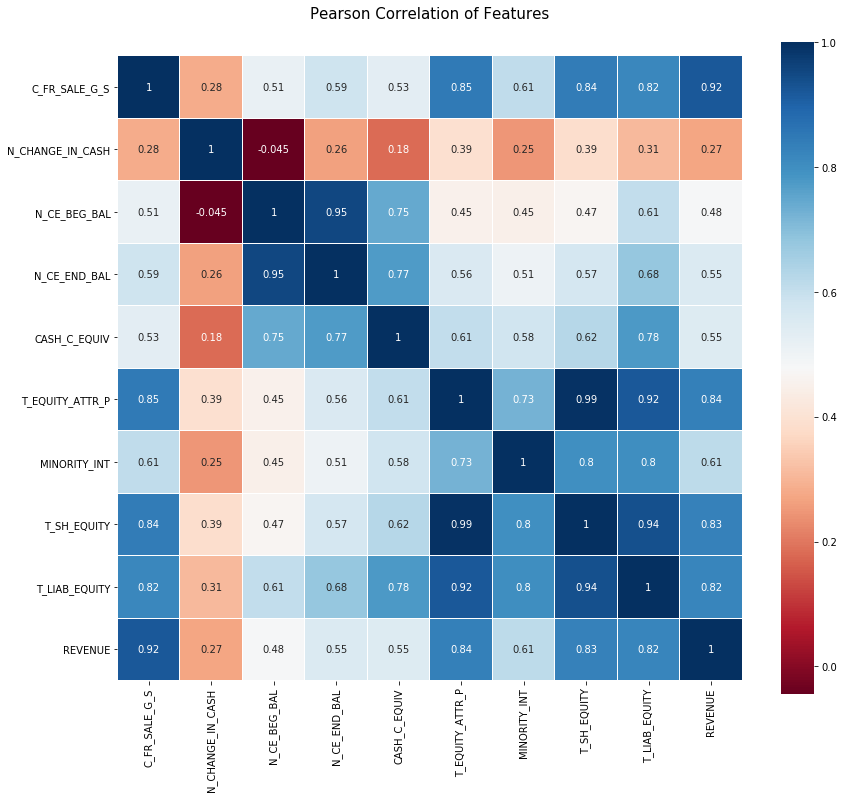

In [229]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [172]:
y_train = train_data['REVENUE'].ravel()
train = train_data.drop(['REVENUE'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test_data.values # Creats an array of the test data

In [173]:
y_train.astype('int')

array([21808652427, 16766330449, 19988838077, 30722991215, 41390345567,
       40961902094, 50266797992, 74795294306])

In [174]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [175]:
# Some useful parameters which will come in handy later on
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 4 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train.astype('int'))

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [176]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [177]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [178]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [179]:
rf_feature = rf.feature_importances(x_train,y_train.astype('int'))
et_feature = et.feature_importances(x_train, y_train.astype('int'))
ada_feature = ada.feature_importances(x_train, y_train.astype('int'))
gb_feature = gb.feature_importances(x_train,y_train.astype('int'))

[0.077 0.086 0.074 0.095 0.098 0.069 0.073 0.081 0.105]
[0.08033333 0.12666667 0.10933333 0.05566667 0.077      0.117
 0.12033333 0.13366667 0.118     ]
[0.048 0.314 0.112 0.14  0.106 0.062 0.076 0.064 0.078]
[0.01820363 0.06478902 0.01753671 0.02239344 0.02153682 0.01149377
 0.01144917 0.01151205 0.0143354 ]


In [180]:
rf_features = [0.077, 0.086, 0.074, 0.095, 0.098, 0.069, 0.073, 0.081, 0.105]
et_features = [0.08033333, 0.12666667, 0.10933333, 0.05566667, 0.077,      0.117,
 0.12033333, 0.13366667, 0.118     ]
ada_features = [0.048, 0.314, 0.112, 0.14,  0.106, 0.062, 0.076, 0.064, 0.078]
gb_features = [0.01820363, 0.06478902, 0.01753671, 0.02239344, 0.02153682, 0.01149377,
 0.01144917, 0.01151205, 0.0143354 ]

In [181]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [182]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,C_FR_SALE_G_S,0.077,0.080333,0.048,0.018204,0.055884
1,N_CHANGE_IN_CASH,0.086,0.126667,0.314,0.064789,0.147864
2,N_CE_BEG_BAL,0.074,0.109333,0.112,0.017537,0.078218


In [183]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,1.998884e+10,1.998884e+10,4.139035e+10,1.998884e+10
1,1.998884e+10,1.998884e+10,4.139035e+10,1.998884e+10
2,1.676633e+10,2.180865e+10,4.096190e+10,2.180865e+10
3,2.180865e+10,2.180865e+10,4.096190e+10,7.479529e+10
4,3.072299e+10,5.026680e+10,1.998884e+10,5.026680e+10


In [184]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [185]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [186]:
predictions

array([1.67663304e+10])

In [187]:
is_data = get_data('IncomeStatement-GeneralBusiness.csv',
                  ['TICKER_SYMBOL', 'END_DATE', 'REPORT_TYPE', 'REVENUE'],
                  '000002', 'S1').reset_index(drop=True)

In [188]:
is_data

,TICKER_SYMBOL,END_DATE,REPORT_TYPE,REVENUE
0,000002,2008-06-30,S1,1.725501e+10
1,000002,2009-06-30,S1,2.180865e+10
2,000002,2010-06-30,S1,1.676633e+10
3,000002,2011-06-30,S1,1.998884e+10
4,000002,2012-06-30,S1,3.072299e+10
5,000002,2013-06-30,S1,4.139035e+10
6,000002,2014-06-30,S1,4.096190e+10
7,000002,2015-06-30,S1,5.026680e+10
8,000002,2016-06-30,S1,7.479529e+10
9,000002,2017-06-30,S1,6.981048e+10
